In [135]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
    
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_perturbation, load_results, create_cdf_proportional_bins, load_weight_changes, load_job, equal_axes, beeswarm

edges = create_cdf_proportional_bins(30, std_dev=1, range_multiplier=2.5)
centers = (edges[1:] + edges[:-1]) / 2

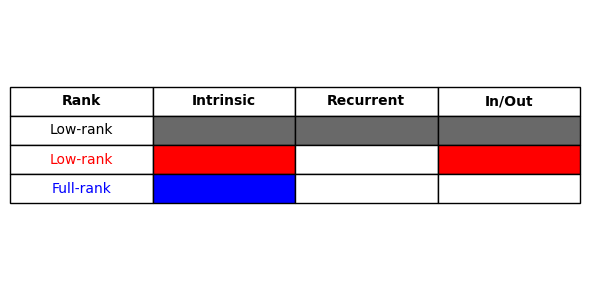

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the table
data = [
    ['Low-rank', '', '', ''],
    ['Low-rank', '', '', ''],
    ['Full-rank', '', '', ''],
    ['Low-rank', '', '', '']
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Hide axes
ax.axis('off')

# Create the table
table = ax.table(cellText=data,
                 colLabels=['Rank', 'Intrinsic', 'Recurrent', 'In/Out'],
                 cellLoc='center',
                 loc='center')

# Set font sizes
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust cell heights and widths
table.scale(1, 1.5)

# Define colors
black = '#696969'
red = '#FF0000'
blue = '#0000FF'
green = '#008000'

# Customize cell colors and text colors
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
    elif col == 0:
        if row == 1:
            cell.set_text_props(color='black')
        elif row == 2:
            cell.set_text_props(color='red')
        elif row == 3:
            cell.set_text_props(color='blue')
        elif row == 4:
            cell.set_text_props(color='green')
    else:
        cell.set_text_props(color='white')  # Set text color to white for visibility
        if row == 1:
            cell.set_facecolor(black if col in [1, 2, 3] else 'white')
        elif row == 2:
            cell.set_facecolor(red if col in [1, 3] else 'white')
        elif row == 3:
            cell.set_facecolor(blue if col == 1 else 'white')
        elif row == 4:
            cell.set_facecolor(green if col == 3 else 'white')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


torch.Size([40, 3000])
torch.Size([40, 3000])
torch.Size([40, 3000])
torch.Size([30, 3000])


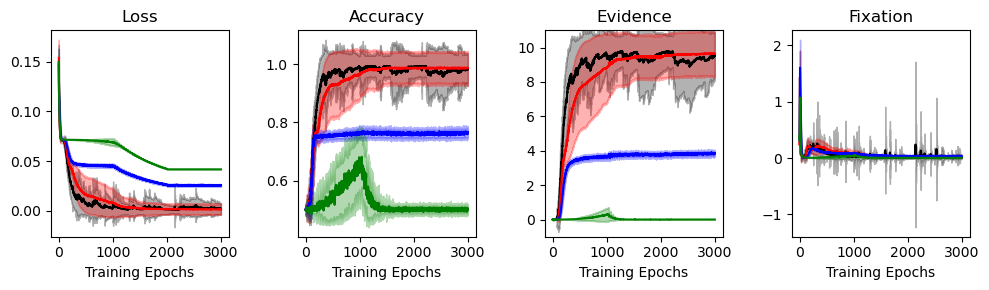

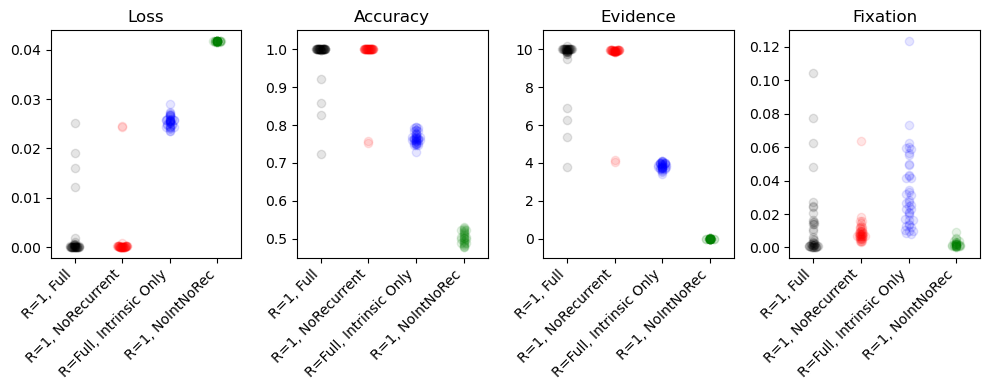

In [191]:
# Comparison of performance across different run types
# jobs = [43, 44, 45, 46, 47]
# names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic"]
# scale = [1, 1, 1, 1, 0.5]
# keepjob = [True, False, False, False, False]

# jobs = [48, 49, 50]
# names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Full-rank Intrinsic"]
# scale = [1, 1, 0.5]
# keepjob = [True, True, True]

jobs = [51, 52, 53, 54]
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Full-rank Intrinsic", "Low-rank, no intrinsic, no recurrent"]
shortnames = ["R=1, Full", "R=1, NoRecurrent", "R=Full, Intrinsic Only", "R=1, NoIntNoRec"]
scale = [1, 1, 1, 1]
keepjob = [True, True, True, True]


figure_name = "LearningComparison"
include_suffix = "_".join(["T" if keep else "F" for keep in keepjob])

loss = []
accuracy = []
evidence = []
fixation = []
for jobid, name in zip(jobs, names):
    train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)
    keep_idx = train_loss[:, -1] < np.inf
    loss.append(train_loss[keep_idx])
    accuracy.append(train_accuracy[keep_idx])
    evidence.append(train_evidence[keep_idx].detach())
    fixation.append(train_fixation[keep_idx].detach())

cols = 'krbgm'
fig, ax = plt.subplots(1, 4, figsize=(10, 3), tight_layout=True)
for ii in range(len(jobs)):
    if not keepjob[ii]:
        continue
    num_epochs = loss[ii].size(1)
    xepochs = np.array(range(num_epochs)) * scale[ii]
    print(loss[ii].shape)
    lmean = loss[ii].mean(dim=0)
    lse = loss[ii].std(dim=0) #/ np.sqrt(loss[ii].size(0))
    amean = accuracy[ii].mean(dim=0)
    ase = accuracy[ii].std(dim=0) #/ np.sqrt(accuracy[ii].size(0))
    emean = evidence[ii].mean(dim=0)
    ese = evidence[ii].std(dim=0) #/ np.sqrt(evidence[ii].size(0))
    fmean = fixation[ii].mean(dim=0)
    fse = fixation[ii].std(dim=0) #/ np.sqrt(fixation[ii].size(0))
    ax[0].plot(xepochs, lmean, color=cols[ii], label=names[ii])
    ax[0].fill_between(xepochs, lmean - lse, lmean + lse, color=cols[ii], alpha=0.3)
    ax[1].plot(xepochs, amean, color=cols[ii], label=names[ii])
    ax[1].fill_between(xepochs, amean - ase, amean + ase, color=cols[ii], alpha=0.3)
    ax[2].plot(xepochs, emean, color=cols[ii], label=names[ii])
    ax[2].fill_between(xepochs, emean - ese, emean + ese, color=cols[ii], alpha=0.3) 
    ax[3].plot(xepochs, fmean, color=cols[ii], label=names[ii])
    ax[3].fill_between(xepochs, fmean - fse, fmean + fse, color=cols[ii], alpha=0.3)

ax[0].set_title("Loss")
ax[0].set_xlabel("Training Epochs")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Training Epochs")
ax[2].set_title("Evidence")
ax[2].set_xlabel("Training Epochs")
ax[2].set_ylim(-1, 11)
ax[3].set_title("Fixation")
ax[3].set_xlabel("Training Epochs")
# plt.savefig(f"../project/{figure_name}_{include_suffix}")
plt.show()

cols = 'krbgm'
fig, ax = plt.subplots(1, 4, figsize=(10, 4), tight_layout=True)
for ii in range(len(jobs)):
    if not keepjob[ii]:
        continue
    num_models = loss[ii].size(0)
    ax[0].scatter(ii + 0.1*beeswarm(loss[ii][:, -1], nbins=100), loss[ii][:, -1], color=cols[ii], label=shortnames[ii], alpha=0.1)
    ax[1].scatter(ii + 0.1*beeswarm(accuracy[ii][:, -1], nbins=100), accuracy[ii][:, -1], color=cols[ii], label=shortnames[ii], alpha=0.1)
    ax[2].scatter(ii + 0.1*beeswarm(evidence[ii][:, -1], nbins=100), evidence[ii][:, -1], color=cols[ii], label=shortnames[ii], alpha=0.1)
    ax[3].scatter(ii + 0.1*beeswarm(fixation[ii][:, -1], nbins=100), fixation[ii][:, -1], color=cols[ii], label=shortnames[ii], alpha=0.1)

for a in ax:
    a.set_xticks(range(len(jobs)))
    a.set_xticklabels(shortnames, rotation=45, ha='right', fontsize=10)
    a.set_xlim(-0.5, len(jobs) - 0.5)

ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[1].set_ylim(0.45, 1.05)
ax[2].set_title("Evidence")
ax[2].set_ylim(-1, 11)
ax[3].set_title("Fixation")
figure_name = "PerformanceSummary"
# plt.savefig(f"../project/{figure_name}")
plt.show()


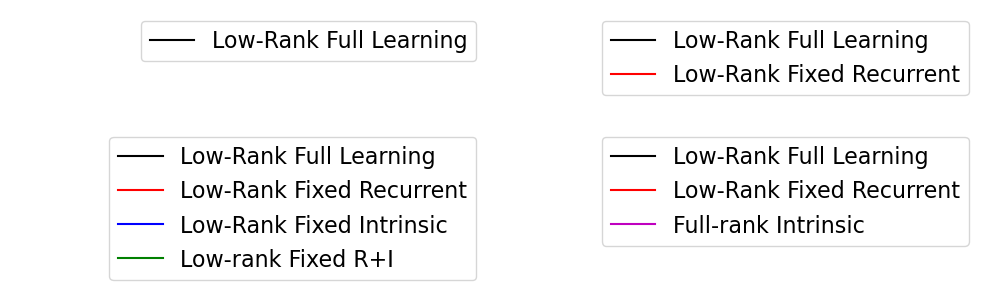

In [102]:
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic"]
to_plot = [[0], [0, 1], [0, 1, 2, 3], [0, 1, 4]]
fig, ax = plt.subplots(2, 2, figsize=(10, 3), tight_layout=True)
ax = np.reshape(ax, -1)
for ii in range(4):
    for jj in to_plot[ii]:
        ax[ii].plot([0, 0], [0, 0], c=cols[jj], label=names[jj])
    ax[ii].legend(fontsize=16)
    ax[ii].axis("off")

plt.savefig(f"../project/{figure_name}_legend")
plt.show()



In [174]:
jobid = 53
init_prms, final_prms = load_weight_changes(jobid)

# jobids = [43, 44, 45, 46, 47]
# jobids = [48, 49, 50]
jobids = [51, 52, 53, 54]
cols = 'krbgm'
color = cols[jobids.index(jobid)]

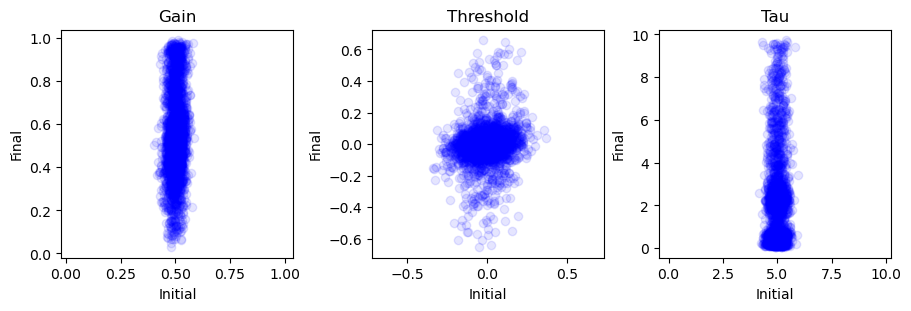

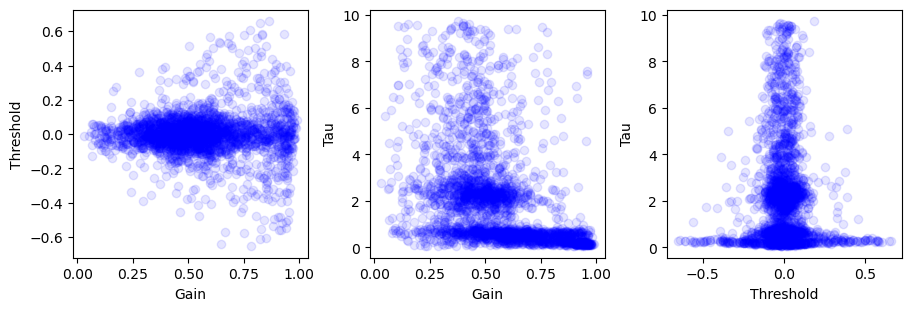

In [175]:

fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].scatter(init_prms["hidden_gain"], final_prms["hidden_gain"], c=color, alpha=0.1)
ax[0].set_xlabel("Initial")
ax[0].set_ylabel("Final")
ax[0].set_title("Gain")
equal_axes(ax[0])

ax[1].scatter(init_prms["hidden_threshold"], final_prms["hidden_threshold"], c=color, alpha=0.1)
ax[1].set_xlabel("Initial")
ax[1].set_ylabel("Final")
ax[1].set_title("Threshold")
equal_axes(ax[1])

ax[2].scatter(init_prms["hidden_tau"], final_prms["hidden_tau"], c=color, alpha=0.1)
ax[2].set_xlabel("Initial")
ax[2].set_ylabel("Final")
ax[2].set_title("Tau")
equal_axes(ax[2])

figure_name = "weight_changes"
# plt.savefig(f"../project/{figure_name}_{jobid}")
plt.show()


fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].scatter(final_prms["hidden_gain"], final_prms["hidden_threshold"], c=color, alpha=0.1)
ax[0].set_xlabel("Gain")
ax[0].set_ylabel("Threshold")

ax[1].scatter(final_prms["hidden_gain"], final_prms["hidden_tau"], c=color, alpha=0.1)
ax[1].set_xlabel("Gain")
ax[1].set_ylabel("Tau")

ax[2].scatter(final_prms["hidden_threshold"], final_prms["hidden_tau"], c=color, alpha=0.1)
ax[2].set_xlabel("Threshold")
ax[2].set_ylabel("Tau")

figure_name = "weight_relations"
# plt.savefig(f"../project/{figure_name}_{jobid}")
plt.show()

[0, 1, 2]


3it [00:00, 235.83it/s]

torch.Size([39, 11, 128])


torch.Size([39, 11, 128])
torch.Size([39, 11, 128])


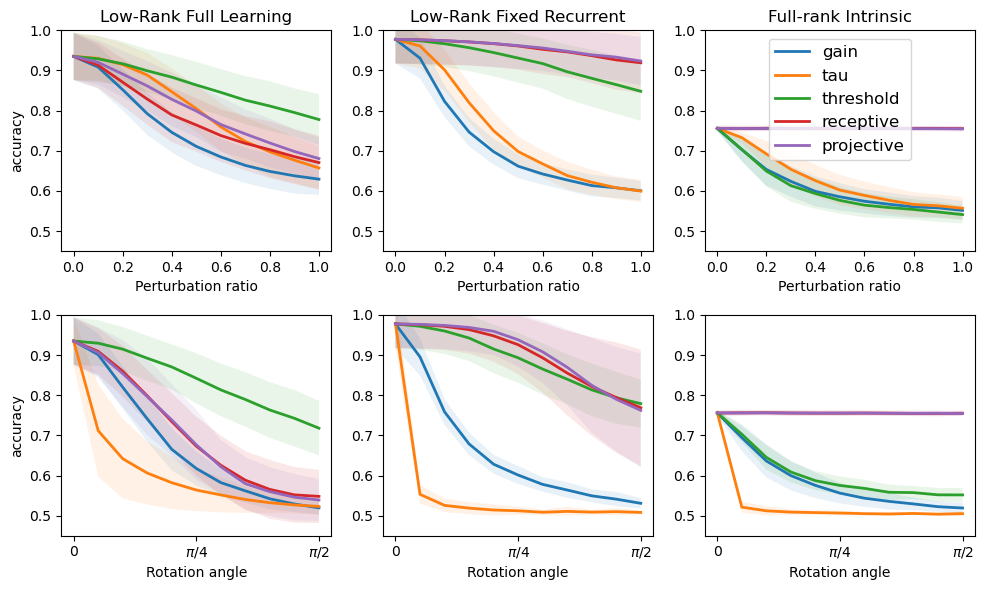

In [189]:
# Comparison of performance across different run types
# jobs = [43, 44, 45, 46, 47]
# names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Low-Rank Fixed Intrinsic", "Low-rank Fixed R+I", "Full-rank Intrinsic Only"]
# keepjob = [True, True, False, False, True]

jobs = [51, 52, 53]
names = ["Low-Rank Full Learning", "Low-Rank Fixed Recurrent", "Full-rank Intrinsic"]
keepjob = [True, True, True]

idxplot = [i for i, keep in enumerate(keepjob) if keep]
figure_name = "PerturbCompare"
include_suffix = "_".join(["T" if keep else "F" for keep in keepjob])

print(idxplot)

loss = []
accuracy = []
evidence = []
fixation = []
loss_rotate = []
accuracy_rotate = []
evidence_rotate = []
fixation_rotate = []

random_ratios = []
rotate_angles = [] 
for jobid, name in tqdm(zip(jobs, names)):
    perturb = load_perturbation(jobid, suffix="random")
    perturb_rotation = load_perturbation(jobid, suffix="rotation")
    loss.append(perturb["loss"])
    accuracy.append(perturb["accuracy"])
    evidence.append(perturb["evidence"].detach())
    fixation.append(perturb["fixation"].detach())
    loss_rotate.append(perturb_rotation["loss"])
    accuracy_rotate.append(perturb_rotation["accuracy"])
    evidence_rotate.append(perturb_rotation["evidence"].detach())
    fixation_rotate.append(perturb_rotation["fixation"].detach())
    random_ratios.append(perturb["perturb_ratios"])
    rotate_angles.append(perturb_rotation["perturb_ratios"])

evaluating = "accuracy"
if evaluating == "accuracy":
    show_perturb = [accuracy, accuracy_rotate]
    ylim = [0.45, 1.0]
    yscale = "linear"
elif evaluating == "loss":
    show_perturb = [loss, loss_rotate]
    ylim = None
    yscale = "log"
elif evaluating == "evidence":
    show_perturb = [evidence, evidence_rotate]
    ylim = None
    yscale = "linear"
elif evaluating == "fixation":
    show_perturb = [fixation, fixation_rotate]
    ylim = None
    yscale = "linear"
else:
    raise ValueError("Invalid evaluation metric")

cmap = plt.get_cmap("tab10")
plt.close('all')
fig, ax = plt.subplots(2, len(idxplot), figsize=(10, 6), tight_layout=True, sharey=False, sharex="row")
for iplot, ii in enumerate(idxplot):
    for jj, target in enumerate(perturb["perturb_targets"]):
        if jj==0:
            print(accuracy[ii][:, :, jj].shape)
        amean = torch.nanmean(show_perturb[0][ii][:, :, jj], dim=(0, 2))
        ase = torch.std(torch.nanmean(show_perturb[0][ii][:, :, jj], dim=2), dim=0) #/ np.sqrt(show_perturb[0][ii].size(0))
        ax[0, iplot].plot(random_ratios[ii], amean, label=f"{target}", c=cmap(jj), linewidth=2)
        ax[0, iplot].fill_between(random_ratios[ii], amean - ase, amean + ase, color=cmap(jj), alpha=0.1, edgecolor=None)
    for jj, target in enumerate(perturb["perturb_targets"]):
        amean = torch.nanmean(show_perturb[1][ii][:, :, jj], dim=(0, 2))
        ase = torch.std(torch.nanmean(show_perturb[1][ii][:, :, jj], dim=2), dim=0) #/ np.sqrt(show_perturb[1][ii].size(0))
        ax[1, iplot].plot(rotate_angles[ii], amean, label=f"{target}", c=cmap(jj), linewidth=2)
        ax[1, iplot].fill_between(rotate_angles[ii], amean - ase, amean + ase, color=cmap(jj), alpha=0.1, edgecolor=None)
    ax[0, iplot].set_title(names[ii])
    ax[0, iplot].set_xlabel("Perturbation ratio")
    ax[1, iplot].set_xlabel("Rotation angle")
    ax[1, iplot].set_xticks([0, np.pi/4, np.pi/2], labels=["0", r"$\pi/4$", r"$\pi/2$"])
    ax[0, iplot].set_ylim(ylim)
    ax[0, iplot].set_yscale(yscale)
    ax[1, iplot].set_ylim(ylim)
    ax[1, iplot].set_yscale(yscale)
ax[0, -1].legend(fontsize=12)
# ax[1, -1].legend(fontsize=12)
ax[0, 0].set_ylabel(evaluating)
ax[1, 0].set_ylabel(evaluating)
# plt.savefig(f"../project/{figure_name}_{evaluating}_{include_suffix}")
plt.show()
